In [ ]:
!pip install pytorch_fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-cp36-none-any.whl size=10547 sha256=5bbf860d5cbcadb709f0e9f607f6a146ac80e27128a79b530d2a414d58474aa2
  Stored in directory: /root/.cache/pip/wheels/72/36/3c/4f3fb256f62d24bef52636f66f21667bc21caa637ce92f0e53
Successfully built pytorch-fid


In [ ]:
# import pytorch_fid.fid_score
# import sys

# from google.colab import drive
# drive.mount('/content/drive')
# drive.mount('/content/drive')


!unzip "/content/drive/MyDrive/AML-Project/fid.zip"


Streaming output truncated to the last 5000 lines.
  inflating: content/stargan/results50000/7/522-images.jpg  
  inflating: content/stargan/results50000/7/378-images.jpg  
  inflating: content/stargan/results50000/7/239-images.jpg  
  inflating: content/stargan/results50000/7/612-images.jpg  
  inflating: content/stargan/results50000/7/394-images.jpg  
  inflating: content/stargan/results50000/7/511-images.jpg  
  inflating: content/stargan/results50000/7/1311-images.jpg  
  inflating: content/stargan/results50000/7/194-images.jpg  
  inflating: content/stargan/results50000/7/724-images.jpg  
  inflating: content/stargan/results50000/7/137-images.jpg  
  inflating: content/stargan/results50000/7/238-images.jpg  
  inflating: content/stargan/results50000/7/221-images.jpg  
  inflating: content/stargan/results50000/7/571-images.jpg  
  inflating: content/stargan/results50000/7/509-images.jpg  
  inflating: content/stargan/results50000/7/590-images.jpg  
  inflating: content/stargan/resu

In [ ]:
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs
The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.
When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).
The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.
See --help to see further details.
Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow
Copyright 2018 Institute of Bioinformatics, JKU Linz
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
from multiprocessing import cpu_count

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

from pytorch_fid.inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--device', type=str, default=None,
                    help='Device to use. Like cuda, cuda:0 or cpu')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('path', type=str, nargs=2,
                    help=('Paths to the generated images or '
                          'to .npz statistic files'))

IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu'):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=cpu_count())

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu'):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
                                        dims, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def fidmain(genArt, srcArt):
    args = parser.parse_args()

    if args.device is None:
        device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    else:
        device = torch.device(args.device)
    print([genArt,srcArt])
    fid_value = calculate_fid_given_paths([genArt,srcArt],
                                          args.batch_size,
                                          device,
                                          args.dims)
    print('FID: ', fid_value)

    return fid_value

In [ ]:
# files = ['/content/drive/MyDrive/AML-Project/stargan/samples/40000-images/{}PNG/{}-image.png'.format(1, x) for x in range(12)]
# control = ['/content/drive/MyDrive/AML-Project/stargan/samples/40000-images/0PNG/{}-image.png'.format(x) for x in range(12)]
import sys

classes = ["Romanticism", "Expressionism", "Pointillism", "Impressionism", "Post-Impressionism", "Northern_Renaissance", "Faces"]
FIDS = {}
sys.argv[1]= '/content/iterations/iteration{}_class{}/'
sys.argv[2]= '/content/drive/MyDrive/AML-Project/comparitors/{}/'
for i in range(1, 8):
  genArt = "/content/content/stargan/results50000/" + str(i)
  srcArt = "/content/FID/" + classes[i-1]
  
  FIDS[classes[i - 1]] = fidmain(genArt,srcArt)

100%|██████████| 32/32 [00:04<00:00,  7.60it/s]


FID:  186.70606331637333


100%|██████████| 31/31 [00:04<00:00,  7.41it/s]


FID:  145.17948657592046


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


FID:  324.2189862368814


100%|██████████| 23/23 [00:03<00:00,  7.46it/s]


FID:  178.14181961938186


100%|██████████| 15/15 [00:02<00:00,  6.97it/s]


FID:  176.02269767163966


100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


FID:  283.39544259068253


100%|██████████| 16/16 [00:02<00:00,  7.39it/s]


FID:  256.64548607988195


{'Romanticism': [146.8326455468548, 200.46005984867844, 194.150526580433, 210.3994834726819, 186.70606331637333, 179.56053880978806], 'Expressionism': [179.94152913060105, 182.57183437751394, 176.63047453300442, 164.65970335627708, 145.17948657592046, 128.43929210453285], 'Pointillism': [291.47886112337255, 322.2239422992209, 330.51217953601065, 319.44032546141955, 324.2189862368814, 306.98805341651575], 'Impressionism': [153.2348824341696, 206.90325409069095, 191.12817419490142, 187.3260445688914, 178.14181961938186, 184.9685997378234], 'Post-Impressionism': [196.43950697871605, 216.1824961989438, 188.7427432085909, 201.4704689252304, 176.02269767163966, 167.05300447869115], 'Northern_Renaissance': [217.6341115280178, 253.90584811657027, 233.71379711542932, 266.76227465919936, 283.39544259068253, 240.1564110876078], 'Faces': [254.92785432767303, 276.9790993073963, 254.9939164362333, 283.4167263903856, 256.64548607988195, 257.6852118684898]}


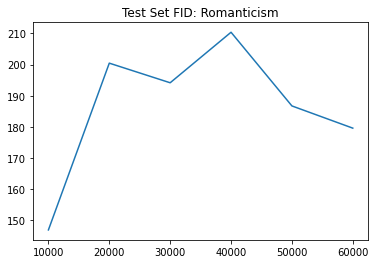

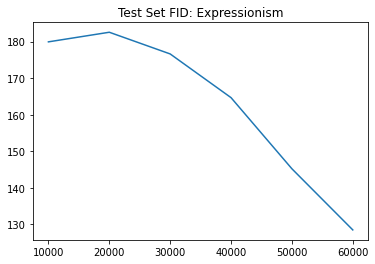

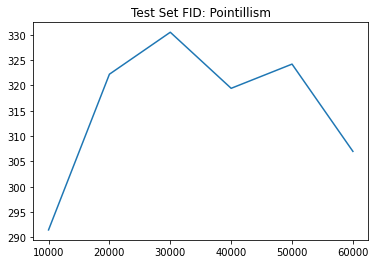

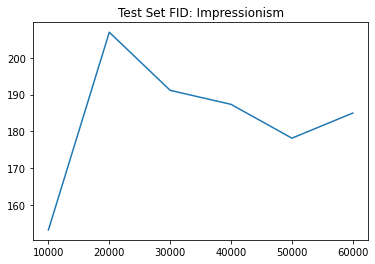

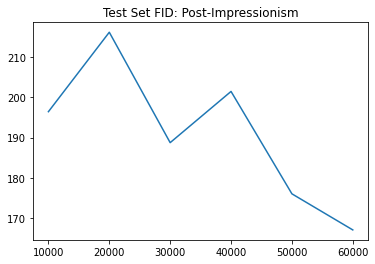

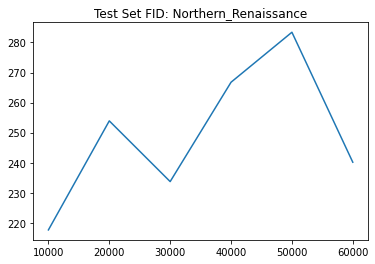

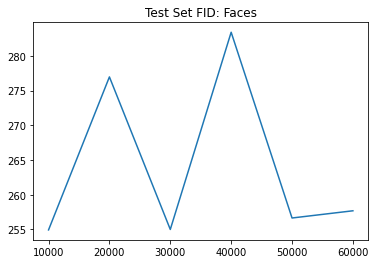

In [ ]:
from matplotlib import pyplot as plt

# fids50000 = FIDS
# print(fids10000)
# print(fids20000)
# print(fids30000)
# print(fids40000)
# print(fids50000)
# print(fids60000)

allFIDS = {}
for i in fids10000.keys():
  allFIDS[i] = []
  allFIDS[i].append(fids10000[i])
  allFIDS[i].append(fids20000[i])
  allFIDS[i].append(fids30000[i])
  allFIDS[i].append(fids40000[i])
  allFIDS[i].append(fids50000[i])
  allFIDS[i].append(fids60000[i])

print(allFIDS)

for i in allFIDS.keys():
  plt.figure()
  plt.title("Test Set FID: " + i)
  plt.plot(np.arange(10000, 70000, 10000), np.array(allFIDS[i]))
  plt.savefig("test-" + i + ".png")


fidstxt = open('fids1-6.txt', 'a')
for i in allFIDS.keys():
  # fidstxt.write(i)
  fidstxt.write("\n")
  for j in allFIDS[i]:
    fidstxt.write(str(j))
    fidstxt.write("\n")
fidstxt.close()





In [ ]:
FIDS

{'Expressionism': 332.2278475074537,
 'Faces': 315.829156497839,
 'Impressionism': 328.12064258298085,
 'Northern_Renaissance': 347.3336344977734,
 'Pointillism': 369.7210703443965,
 'Post-Impressionism': 314.47132713937106,
 'Romanticism': 364.2363947656837}

In [ ]:
import collections
files = ['/content/drive/MyDrive/AML-Project/stargan/samples/40000-images/{}PNG/{}-image.png'.format(1, x) for x in range(12)]
control = ['/content/drive/MyDrive/AML-Project/stargan/samples/40000-images/0PNG/{}-image.png'.format(x) for x in range(12)]

classes = ["High_Renaissance", "Expressionism", "Rococo", "Impressionism", "Realism"]
FIDS = collections.defaultdict(list)

it = 10000
while it <= 60000:
  for i in range(1, 6):
    # sys.argv[1]= '/content/drive/MyDrive/AML-Project/stargan60000-iterations/iteration{}_class{}/'.format(it, i)
    # sys.argv[2]= '/content/drive/MyDrive/AML-Project/comparitors/{}/'.format(classes[i])
    sys.argv[1]= '/content/iterations/iteration{}_class{}/'.format(it, i)
    sys.argv[2]= '/content/drive/MyDrive/AML-Project/comparitors/{}/'.format(classes[i - 1])
    x = main()
    FIDS[classes[i - 1]].append(x)
  it += 10000



  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.27it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


FID:  309.4697898947725




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:21,  1.40it/s]

  6%|▋         | 2/31 [00:00<00:16,  1.78it/s]

 10%|▉         | 3/31 [00:01<00:13,  2.13it/s]

 13%|█▎        | 4/31 [00:01<00:10,  2.55it/s]

 16%|█▌        | 5/31 [00:01<00:08,  2.95it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.39it/s]

 23%|██▎       | 7/31 [00:02<00:07,  3.42it/s]

 26%|██▌       | 8/31 [00:02<00:06,  3.76it/s]

 29%|██▉       | 9/31 [00:02<00:05,  4.01it/s]

 32%|███▏      | 10/31 [00:02<00:04,  4.31it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.07it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.28it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.09it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.33it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.17it/s]

 52%|█████▏    | 16/31 [00:04<00:03,  4.37it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.52it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.54it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  305.28429547712324




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:12,  1.41it/s]

 11%|█         | 2/18 [00:00<00:08,  1.79it/s]

 17%|█▋        | 3/18 [00:01<00:07,  2.13it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.55it/s]

 28%|██▊       | 5/18 [00:01<00:04,  2.88it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.27it/s]

 39%|███▉      | 7/18 [00:02<00:03,  3.45it/s]

 44%|████▍     | 8/18 [00:02<00:02,  3.79it/s]

 50%|█████     | 9/18 [00:02<00:02,  3.97it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.20it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.12it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  4.29it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.27it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.41it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.32it/s]

 89%|████████▉ | 16/18 [00:04<00:00,  4.41it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.62it/s]

100%|██████████| 18/18 [00:04<00:00,  4.01it/s]


FID:  306.97826827715915




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:17,  1.28it/s]

  9%|▊         | 2/23 [00:00<00:12,  1.66it/s]

 13%|█▎        | 3/23 [00:01<00:09,  2.04it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.50it/s]

 22%|██▏       | 5/23 [00:01<00:06,  2.71it/s]

 26%|██▌       | 6/23 [00:01<00:05,  3.13it/s]

 30%|███       | 7/23 [00:02<00:04,  3.27it/s]

 35%|███▍      | 8/23 [00:02<00:04,  3.64it/s]

 39%|███▉      | 9/23 [00:02<00:03,  3.75it/s]

 43%|████▎     | 10/23 [00:02<00:03,  4.05it/s]

 48%|████▊     | 11/23 [00:03<00:03,  3.94it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.16it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.06it/s]

 61%|██████    | 14/23 [00:03<00:02,  4.28it/s]

 65%|██████▌   | 15/23 [00:04<00:01,  4.20it/s]

 70%|██████▉   | 16/23 [00:04<00:01,  4.39it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.07it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.31it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  319.107059196761




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:25,  1.43it/s]

  5%|▌         | 2/37 [00:00<00:19,  1.81it/s]

  8%|▊         | 3/37 [00:01<00:15,  2.23it/s]

 11%|█         | 4/37 [00:01<00:12,  2.67it/s]

 14%|█▎        | 5/37 [00:01<00:10,  2.97it/s]

 16%|█▌        | 6/37 [00:01<00:09,  3.37it/s]

 19%|█▉        | 7/37 [00:01<00:08,  3.66it/s]

 22%|██▏       | 8/37 [00:02<00:07,  3.94it/s]

 24%|██▍       | 9/37 [00:02<00:07,  3.95it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.20it/s]

 30%|██▉       | 11/37 [00:02<00:06,  3.96it/s]

 32%|███▏      | 12/37 [00:03<00:06,  4.16it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.09it/s]

 38%|███▊      | 14/37 [00:03<00:05,  4.29it/s]

 41%|████      | 15/37 [00:03<00:05,  4.32it/s]

 43%|████▎     | 16/37 [00:04<00:04,  4.50it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.18it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.40it/s]

 51%|█████▏    | 19/37 [00:04<00:04, 

FID:  312.6265027348634




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.40it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.79it/s]

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


FID:  259.92465771947207




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:21,  1.42it/s]

  6%|▋         | 2/31 [00:00<00:16,  1.80it/s]

 10%|▉         | 3/31 [00:01<00:12,  2.18it/s]

 13%|█▎        | 4/31 [00:01<00:10,  2.62it/s]

 16%|█▌        | 5/31 [00:01<00:08,  2.91it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.33it/s]

 23%|██▎       | 7/31 [00:02<00:06,  3.49it/s]

 26%|██▌       | 8/31 [00:02<00:06,  3.83it/s]

 29%|██▉       | 9/31 [00:02<00:05,  3.77it/s]

 32%|███▏      | 10/31 [00:02<00:05,  4.02it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.10it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.28it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.44it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.51it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.58it/s]

 52%|█████▏    | 16/31 [00:04<00:03,  4.70it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.48it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.62it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  299.1956508928113




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:11,  1.42it/s]

 11%|█         | 2/18 [00:00<00:08,  1.80it/s]

 17%|█▋        | 3/18 [00:01<00:06,  2.23it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.65it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.05it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.45it/s]

 39%|███▉      | 7/18 [00:01<00:02,  3.81it/s]

 44%|████▍     | 8/18 [00:02<00:02,  4.02it/s]

 50%|█████     | 9/18 [00:02<00:02,  4.20it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.33it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.37it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  4.55it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.46it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.48it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.45it/s]

 89%|████████▉ | 16/18 [00:03<00:00,  4.59it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.40it/s]

100%|██████████| 18/18 [00:04<00:00,  4.15it/s]


FID:  295.71168662372327




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:14,  1.48it/s]

  9%|▊         | 2/23 [00:00<00:11,  1.87it/s]

 13%|█▎        | 3/23 [00:01<00:08,  2.29it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.71it/s]

 22%|██▏       | 5/23 [00:01<00:05,  3.02it/s]

 26%|██▌       | 6/23 [00:01<00:04,  3.43it/s]

 30%|███       | 7/23 [00:02<00:04,  3.55it/s]

 35%|███▍      | 8/23 [00:02<00:03,  3.86it/s]

 39%|███▉      | 9/23 [00:02<00:03,  3.90it/s]

 43%|████▎     | 10/23 [00:02<00:03,  4.12it/s]

 48%|████▊     | 11/23 [00:02<00:02,  4.33it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.48it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.56it/s]

 61%|██████    | 14/23 [00:03<00:01,  4.65it/s]

 65%|██████▌   | 15/23 [00:03<00:01,  4.58it/s]

 70%|██████▉   | 16/23 [00:03<00:01,  4.68it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.69it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.75it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  303.17723416821076




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:26,  1.37it/s]

  5%|▌         | 2/37 [00:00<00:20,  1.75it/s]

  8%|▊         | 3/37 [00:01<00:15,  2.15it/s]

 11%|█         | 4/37 [00:01<00:12,  2.61it/s]

 14%|█▎        | 5/37 [00:01<00:11,  2.89it/s]

 16%|█▌        | 6/37 [00:01<00:09,  3.33it/s]

 19%|█▉        | 7/37 [00:02<00:08,  3.49it/s]

 22%|██▏       | 8/37 [00:02<00:07,  3.85it/s]

 24%|██▍       | 9/37 [00:02<00:07,  3.85it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.13it/s]

 30%|██▉       | 11/37 [00:02<00:06,  4.26it/s]

 32%|███▏      | 12/37 [00:03<00:05,  4.40it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.27it/s]

 38%|███▊      | 14/37 [00:03<00:05,  4.45it/s]

 41%|████      | 15/37 [00:03<00:05,  4.34it/s]

 43%|████▎     | 16/37 [00:04<00:04,  4.52it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.53it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.64it/s]

 51%|█████▏    | 19/37 [00:04<00:03, 

FID:  277.17280338441947




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.52it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


FID:  311.214035959886




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:20,  1.44it/s]

  6%|▋         | 2/31 [00:00<00:15,  1.83it/s]

 10%|▉         | 3/31 [00:01<00:12,  2.27it/s]

 13%|█▎        | 4/31 [00:01<00:09,  2.73it/s]

 16%|█▌        | 5/31 [00:01<00:08,  3.03it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.43it/s]

 23%|██▎       | 7/31 [00:02<00:06,  3.51it/s]

 26%|██▌       | 8/31 [00:02<00:06,  3.83it/s]

 29%|██▉       | 9/31 [00:02<00:05,  4.10it/s]

 32%|███▏      | 10/31 [00:02<00:04,  4.34it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.22it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.48it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.44it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.56it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.27it/s]

 52%|█████▏    | 16/31 [00:03<00:03,  4.45it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.47it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.57it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  304.5371999990084




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:11,  1.46it/s]

 11%|█         | 2/18 [00:00<00:08,  1.85it/s]

 17%|█▋        | 3/18 [00:01<00:06,  2.26it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.69it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.10it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.44it/s]

 39%|███▉      | 7/18 [00:01<00:02,  3.74it/s]

 44%|████▍     | 8/18 [00:02<00:02,  4.05it/s]

 50%|█████     | 9/18 [00:02<00:02,  4.24it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.39it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.49it/s]

 67%|██████▋   | 12/18 [00:02<00:01,  4.66it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.65it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.75it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.56it/s]

 89%|████████▉ | 16/18 [00:03<00:00,  4.65it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.63it/s]

100%|██████████| 18/18 [00:04<00:00,  4.24it/s]


FID:  306.2005117554327




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:17,  1.29it/s]

  9%|▊         | 2/23 [00:00<00:12,  1.66it/s]

 13%|█▎        | 3/23 [00:01<00:09,  2.06it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.48it/s]

 22%|██▏       | 5/23 [00:01<00:06,  2.86it/s]

 26%|██▌       | 6/23 [00:01<00:05,  3.25it/s]

 30%|███       | 7/23 [00:02<00:04,  3.60it/s]

 35%|███▍      | 8/23 [00:02<00:03,  3.89it/s]

 39%|███▉      | 9/23 [00:02<00:03,  3.92it/s]

 43%|████▎     | 10/23 [00:02<00:03,  4.15it/s]

 48%|████▊     | 11/23 [00:02<00:02,  4.34it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.58it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.66it/s]

 61%|██████    | 14/23 [00:03<00:01,  4.73it/s]

 65%|██████▌   | 15/23 [00:03<00:01,  4.57it/s]

 70%|██████▉   | 16/23 [00:03<00:01,  4.72it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.73it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.78it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  338.401536224427




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:25,  1.41it/s]

  5%|▌         | 2/37 [00:00<00:19,  1.79it/s]

  8%|▊         | 3/37 [00:01<00:15,  2.20it/s]

 11%|█         | 4/37 [00:01<00:12,  2.64it/s]

 14%|█▎        | 5/37 [00:01<00:10,  3.07it/s]

 16%|█▌        | 6/37 [00:01<00:08,  3.46it/s]

 19%|█▉        | 7/37 [00:01<00:08,  3.72it/s]

 22%|██▏       | 8/37 [00:02<00:07,  4.02it/s]

 24%|██▍       | 9/37 [00:02<00:06,  4.18it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.38it/s]

 30%|██▉       | 11/37 [00:02<00:06,  4.24it/s]

 32%|███▏      | 12/37 [00:03<00:05,  4.36it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.51it/s]

 38%|███▊      | 14/37 [00:03<00:05,  4.57it/s]

 41%|████      | 15/37 [00:03<00:04,  4.65it/s]

 43%|████▎     | 16/37 [00:03<00:04,  4.73it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.64it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.69it/s]

 51%|█████▏    | 19/37 [00:04<00:03, 

FID:  318.53837121722563




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.34it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.71it/s]

100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


FID:  371.2712761583223




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:22,  1.35it/s]

  6%|▋         | 2/31 [00:00<00:16,  1.73it/s]

 10%|▉         | 3/31 [00:01<00:13,  2.13it/s]

 13%|█▎        | 4/31 [00:01<00:10,  2.57it/s]

 16%|█▌        | 5/31 [00:01<00:08,  3.02it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.42it/s]

 23%|██▎       | 7/31 [00:01<00:06,  3.63it/s]

 26%|██▌       | 8/31 [00:02<00:05,  3.97it/s]

 29%|██▉       | 9/31 [00:02<00:05,  3.99it/s]

 32%|███▏      | 10/31 [00:02<00:04,  4.24it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.23it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.44it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.27it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.39it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.50it/s]

 52%|█████▏    | 16/31 [00:03<00:03,  4.52it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.57it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.59it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  302.0279799526263




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:12,  1.40it/s]

 11%|█         | 2/18 [00:00<00:09,  1.78it/s]

 17%|█▋        | 3/18 [00:01<00:06,  2.20it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.65it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.01it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.44it/s]

 39%|███▉      | 7/18 [00:02<00:03,  3.38it/s]

 44%|████▍     | 8/18 [00:02<00:02,  3.75it/s]

 50%|█████     | 9/18 [00:02<00:02,  3.86it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.17it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.03it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  4.30it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.10it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.28it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.23it/s]

 89%|████████▉ | 16/18 [00:04<00:00,  4.44it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.65it/s]

100%|██████████| 18/18 [00:04<00:00,  4.03it/s]


FID:  340.8361078954904




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:15,  1.38it/s]

  9%|▊         | 2/23 [00:00<00:12,  1.74it/s]

 13%|█▎        | 3/23 [00:01<00:09,  2.13it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.57it/s]

 22%|██▏       | 5/23 [00:01<00:06,  2.96it/s]

 26%|██▌       | 6/23 [00:01<00:05,  3.38it/s]

 30%|███       | 7/23 [00:01<00:04,  3.73it/s]

 35%|███▍      | 8/23 [00:02<00:03,  3.94it/s]

 39%|███▉      | 9/23 [00:02<00:03,  4.18it/s]

 43%|████▎     | 10/23 [00:02<00:02,  4.37it/s]

 48%|████▊     | 11/23 [00:02<00:02,  4.43it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.50it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.46it/s]

 61%|██████    | 14/23 [00:03<00:01,  4.60it/s]

 65%|██████▌   | 15/23 [00:03<00:01,  4.40it/s]

 70%|██████▉   | 16/23 [00:03<00:01,  4.56it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.26it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.47it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  323.5499752410813




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:25,  1.43it/s]

  5%|▌         | 2/37 [00:00<00:19,  1.81it/s]

  8%|▊         | 3/37 [00:01<00:15,  2.21it/s]

 11%|█         | 4/37 [00:01<00:12,  2.66it/s]

 14%|█▎        | 5/37 [00:01<00:10,  3.02it/s]

 16%|█▌        | 6/37 [00:01<00:09,  3.41it/s]

 19%|█▉        | 7/37 [00:02<00:08,  3.52it/s]

 22%|██▏       | 8/37 [00:02<00:07,  3.86it/s]

 24%|██▍       | 9/37 [00:02<00:07,  3.97it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.19it/s]

 30%|██▉       | 11/37 [00:02<00:06,  4.08it/s]

 32%|███▏      | 12/37 [00:03<00:05,  4.28it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.45it/s]

 38%|███▊      | 14/37 [00:03<00:04,  4.65it/s]

 41%|████      | 15/37 [00:03<00:05,  4.39it/s]

 43%|████▎     | 16/37 [00:04<00:04,  4.46it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.51it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.57it/s]

 51%|█████▏    | 19/37 [00:04<00:04, 

FID:  331.21884841061984




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.47it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.86it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


FID:  375.9884617812394




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:21,  1.42it/s]

  6%|▋         | 2/31 [00:00<00:16,  1.81it/s]

 10%|▉         | 3/31 [00:01<00:12,  2.18it/s]

 13%|█▎        | 4/31 [00:01<00:10,  2.60it/s]

 16%|█▌        | 5/31 [00:01<00:09,  2.86it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.24it/s]

 23%|██▎       | 7/31 [00:02<00:07,  3.33it/s]

 26%|██▌       | 8/31 [00:02<00:06,  3.67it/s]

 29%|██▉       | 9/31 [00:02<00:05,  3.97it/s]

 32%|███▏      | 10/31 [00:02<00:04,  4.24it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.19it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.35it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.48it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.59it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.42it/s]

 52%|█████▏    | 16/31 [00:04<00:03,  4.50it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.59it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.66it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  298.8571225297329




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:11,  1.43it/s]

 11%|█         | 2/18 [00:00<00:08,  1.81it/s]

 17%|█▋        | 3/18 [00:01<00:06,  2.24it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.68it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.10it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.49it/s]

 39%|███▉      | 7/18 [00:01<00:03,  3.61it/s]

 44%|████▍     | 8/18 [00:02<00:02,  3.92it/s]

 50%|█████     | 9/18 [00:02<00:02,  4.02it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.22it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.24it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  4.43it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.34it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.42it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.29it/s]

 89%|████████▉ | 16/18 [00:03<00:00,  4.50it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.58it/s]

100%|██████████| 18/18 [00:04<00:00,  4.12it/s]


FID:  343.27579648599993




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:15,  1.39it/s]

  9%|▊         | 2/23 [00:00<00:11,  1.78it/s]

 13%|█▎        | 3/23 [00:01<00:09,  2.21it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.63it/s]

 22%|██▏       | 5/23 [00:01<00:06,  2.97it/s]

 26%|██▌       | 6/23 [00:01<00:05,  3.37it/s]

 30%|███       | 7/23 [00:02<00:04,  3.55it/s]

 35%|███▍      | 8/23 [00:02<00:03,  3.88it/s]

 39%|███▉      | 9/23 [00:02<00:03,  3.96it/s]

 43%|████▎     | 10/23 [00:02<00:03,  4.20it/s]

 48%|████▊     | 11/23 [00:02<00:02,  4.19it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.36it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.28it/s]

 61%|██████    | 14/23 [00:03<00:02,  4.42it/s]

 65%|██████▌   | 15/23 [00:03<00:01,  4.36it/s]

 70%|██████▉   | 16/23 [00:04<00:01,  4.50it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.31it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.46it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  325.151328158102




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:24,  1.47it/s]

  5%|▌         | 2/37 [00:00<00:18,  1.86it/s]

  8%|▊         | 3/37 [00:01<00:14,  2.28it/s]

 11%|█         | 4/37 [00:01<00:12,  2.75it/s]

 14%|█▎        | 5/37 [00:01<00:10,  2.99it/s]

 16%|█▌        | 6/37 [00:01<00:09,  3.37it/s]

 19%|█▉        | 7/37 [00:02<00:08,  3.48it/s]

 22%|██▏       | 8/37 [00:02<00:07,  3.85it/s]

 24%|██▍       | 9/37 [00:02<00:07,  3.85it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.12it/s]

 30%|██▉       | 11/37 [00:02<00:06,  4.33it/s]

 32%|███▏      | 12/37 [00:03<00:05,  4.53it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.29it/s]

 38%|███▊      | 14/37 [00:03<00:05,  4.45it/s]

 41%|████      | 15/37 [00:03<00:04,  4.52it/s]

 43%|████▎     | 16/37 [00:03<00:04,  4.59it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.42it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.60it/s]

 51%|█████▏    | 19/37 [00:04<00:03, 

FID:  325.00349948904994




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]

 50%|█████     | 2/4 [00:00<00:01,  1.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


FID:  378.04854592571996




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:00<00:21,  1.37it/s]

  6%|▋         | 2/31 [00:00<00:16,  1.75it/s]

 10%|▉         | 3/31 [00:01<00:12,  2.16it/s]

 13%|█▎        | 4/31 [00:01<00:10,  2.61it/s]

 16%|█▌        | 5/31 [00:01<00:08,  3.05it/s]

 19%|█▉        | 6/31 [00:01<00:07,  3.45it/s]

 23%|██▎       | 7/31 [00:01<00:06,  3.79it/s]

 26%|██▌       | 8/31 [00:02<00:05,  4.08it/s]

 29%|██▉       | 9/31 [00:02<00:05,  4.21it/s]

 32%|███▏      | 10/31 [00:02<00:04,  4.40it/s]

 35%|███▌      | 11/31 [00:02<00:04,  4.28it/s]

 39%|███▊      | 12/31 [00:03<00:04,  4.46it/s]

 42%|████▏     | 13/31 [00:03<00:04,  4.49it/s]

 45%|████▌     | 14/31 [00:03<00:03,  4.61it/s]

 48%|████▊     | 15/31 [00:03<00:03,  4.51it/s]

 52%|█████▏    | 16/31 [00:03<00:03,  4.62it/s]

 55%|█████▍    | 17/31 [00:04<00:03,  4.32it/s]

 58%|█████▊    | 18/31 [00:04<00:02,  4.49it/s]

 61%|██████▏   | 19/31 [00:04<00:02, 

FID:  290.2448312080526




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:00<00:12,  1.40it/s]

 11%|█         | 2/18 [00:00<00:08,  1.78it/s]

 17%|█▋        | 3/18 [00:01<00:06,  2.20it/s]

 22%|██▏       | 4/18 [00:01<00:05,  2.64it/s]

 28%|██▊       | 5/18 [00:01<00:04,  3.02it/s]

 33%|███▎      | 6/18 [00:01<00:03,  3.35it/s]

 39%|███▉      | 7/18 [00:01<00:02,  3.67it/s]

 44%|████▍     | 8/18 [00:02<00:02,  3.98it/s]

 50%|█████     | 9/18 [00:02<00:02,  4.20it/s]

 56%|█████▌    | 10/18 [00:02<00:01,  4.40it/s]

 61%|██████    | 11/18 [00:02<00:01,  4.52it/s]

 67%|██████▋   | 12/18 [00:03<00:01,  4.65it/s]

 72%|███████▏  | 13/18 [00:03<00:01,  4.63it/s]

 78%|███████▊  | 14/18 [00:03<00:00,  4.72it/s]

 83%|████████▎ | 15/18 [00:03<00:00,  4.54it/s]

 89%|████████▉ | 16/18 [00:03<00:00,  4.56it/s]

 94%|█████████▍| 17/18 [00:04<00:00,  4.75it/s]

100%|██████████| 18/18 [00:04<00:00,  4.22it/s]


FID:  329.80676727575633




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


  0%|          | 0/23 [00:00<?, ?it/s]

  4%|▍         | 1/23 [00:00<00:16,  1.37it/s]

  9%|▊         | 2/23 [00:00<00:12,  1.74it/s]

 13%|█▎        | 3/23 [00:01<00:09,  2.15it/s]

 17%|█▋        | 4/23 [00:01<00:07,  2.59it/s]

 22%|██▏       | 5/23 [00:01<00:05,  3.00it/s]

 26%|██▌       | 6/23 [00:01<00:04,  3.41it/s]

 30%|███       | 7/23 [00:01<00:04,  3.63it/s]

 35%|███▍      | 8/23 [00:02<00:03,  3.99it/s]

 39%|███▉      | 9/23 [00:02<00:03,  3.92it/s]

 43%|████▎     | 10/23 [00:02<00:03,  4.20it/s]

 48%|████▊     | 11/23 [00:02<00:02,  4.18it/s]

 52%|█████▏    | 12/23 [00:03<00:02,  4.37it/s]

 57%|█████▋    | 13/23 [00:03<00:02,  4.31it/s]

 61%|██████    | 14/23 [00:03<00:02,  4.45it/s]

 65%|██████▌   | 15/23 [00:03<00:01,  4.55it/s]

 70%|██████▉   | 16/23 [00:03<00:01,  4.60it/s]

 74%|███████▍  | 17/23 [00:04<00:01,  4.68it/s]

 78%|███████▊  | 18/23 [00:04<00:01,  4.76it/s]

 83%|████████▎ | 19/23 [00:04<00:00, 

FID:  327.0351001876874




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:26,  1.34it/s]

  5%|▌         | 2/37 [00:00<00:20,  1.71it/s]

  8%|▊         | 3/37 [00:01<00:16,  2.11it/s]

 11%|█         | 4/37 [00:01<00:12,  2.54it/s]

 14%|█▎        | 5/37 [00:01<00:10,  2.98it/s]

 16%|█▌        | 6/37 [00:01<00:09,  3.37it/s]

 19%|█▉        | 7/37 [00:02<00:08,  3.58it/s]

 22%|██▏       | 8/37 [00:02<00:07,  3.92it/s]

 24%|██▍       | 9/37 [00:02<00:06,  4.10it/s]

 27%|██▋       | 10/37 [00:02<00:06,  4.27it/s]

 30%|██▉       | 11/37 [00:02<00:05,  4.42it/s]

 32%|███▏      | 12/37 [00:03<00:05,  4.58it/s]

 35%|███▌      | 13/37 [00:03<00:05,  4.61it/s]

 38%|███▊      | 14/37 [00:03<00:04,  4.70it/s]

 41%|████      | 15/37 [00:03<00:04,  4.54it/s]

 43%|████▎     | 16/37 [00:03<00:04,  4.63it/s]

 46%|████▌     | 17/37 [00:04<00:04,  4.42it/s]

 49%|████▊     | 18/37 [00:04<00:04,  4.55it/s]

 51%|█████▏    | 19/37 [00:04<00:04, 

FID:  301.9569754174364


In [ ]:
!unzip '/content/drive/MyDrive/AML-Project/stargan60000-iterations/iterations.zip'

Archive:  /content/drive/MyDrive/AML-Project/stargan60000-iterations/iterations.zip
replace iterations/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

High_Renaissance lowest FID: 259.92465771947207
Expressionism lowest FID: 290.2448312080526
Rococo lowest FID: 295.71168662372327
Impressionism lowest FID: 303.17723416821076
Realism lowest FID: 277.17280338441947


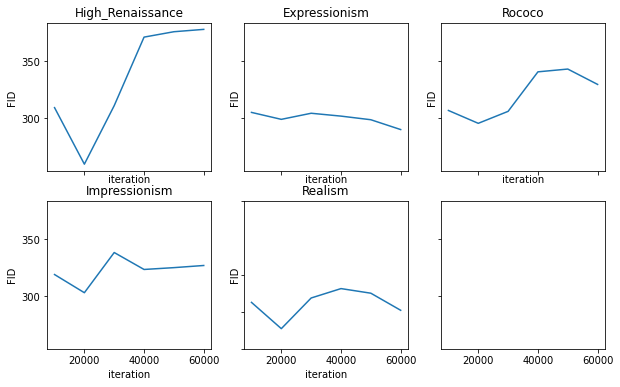

In [ ]:
from matplotlib import pyplot as plt

X = [10000, 20000, 30000, 40000, 50000, 60000]
i = 0
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for k, v in FIDS.items():
  c = i % 3
  r = (i // 3)
  axs[r, c].plot(X, v)
  axs[r, c].set_xlabel("iteration")
  axs[r, c].set_ylabel("FID")
  axs[r, c].set_yticks([250, 300, 350, 450])
  axs[r, c].set_title(classes[i])
  print("{} lowest FID: {}".format(classes[i], min(v)))
  i += 1
plt.show()

In [ ]:
111